In [1]:
from gpt2vec.models.gemma3 import biGemma3ForMaskedLM, biGemma3ForMaskedNTP, biGemma3ForTokenClassification, Gemma3ForCausalLM
from transformers import AutoModelForMaskedLM, AutoModelForCausalLM, AutoTokenizer

from torch.utils.data import DataLoader
from datasets import load_dataset

from transformers import AutoModelForTokenClassification, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, get_peft_model, LoraConfig, TaskType

import torch
import numpy as np

from matplotlib import pyplot as plt

In [2]:
PRETRAINED_MODEL = "microsoft/mdeberta-v3-base"
# PRETRAINED_MODEL = "google/gemma-3-1b-pt"

In [3]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

model = AutoModelForMaskedLM.from_pretrained(
    PRETRAINED_MODEL,
    return_dict_in_generate=True,
    output_attentions=True
).eval()

model.cuda()


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/venv/main/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForMaskedLM(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(251000, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [4]:
ds_eval   = load_dataset("wikitext", "wikitext-2-raw-v1", split="validation")


def collate(examples):
    enc = tokenizer(
        [ex["text"] for ex in examples],
        padding="longest",
        truncation=True,
        return_tensors="pt",
        max_length=128,
    )
    return {k: v.cuda() for k, v in enc.items()}


loader = DataLoader(ds_eval, batch_size=8, collate_fn=collate)

In [5]:
for batch in loader:
    break

In [6]:
batch

{'input_ids': tensor([[     1,      2,      0,  ...,      0,      0,      0],
         [     1,    260,    350,  ...,      0,      0,      0],
         [     1,      2,      0,  ...,      0,      0,      0],
         ...,
         [     1,    260,    350,  ...,      0,      0,      0],
         [     1,      2,      0,  ...,      0,      0,      0],
         [     1,  40350, 196109,  ...,    260,    263,      2]],
        device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 0,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')}

In [7]:
with torch.no_grad():
    out = model(**batch)

In [8]:
model

DebertaV2ForMaskedLM(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(251000, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [23]:
out.attentions[0][3].max(dim=0).values.cpu()

tensor([[3.8458e-01, 2.9414e-01, 2.5843e-02,  ..., 4.1201e-03, 4.1165e-02,
         2.6374e-01],
        [2.5869e-01, 6.0872e-04, 6.2921e-01,  ..., 6.7735e-03, 1.8833e-02,
         4.6534e-01],
        [3.8938e-01, 3.5558e-01, 1.7750e-03,  ..., 6.8543e-03, 3.0341e-02,
         2.9033e-01],
        ...,
        [3.7046e-01, 1.9581e-03, 6.1888e-03,  ..., 7.5393e-04, 2.9197e-01,
         5.7826e-01],
        [3.8789e-01, 1.5025e-03, 1.7122e-03,  ..., 9.5486e-02, 7.7430e-02,
         2.9749e-01],
        [2.6198e-01, 2.5401e-03, 4.3379e-03,  ..., 3.5724e-02, 9.1126e-01,
         3.6164e-01]], device='cuda:0')

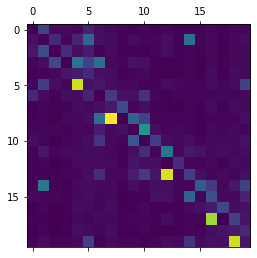

In [26]:
plt.matshow(out.attentions[0][3].max(dim=0).values.cpu()[80:100, 80:100])

In [12]:
import torch

def uter_per_layer(attentions: tuple[torch.Tensor]) -> list[float]:
    """
    attentions : tuple(L tensors)  each (B, H, S, S) – soft-maxed weights
    returns    : [uter_L0, uter_L1, …]    averaged over batch & heads
    """
    uters = []
    for A in attentions:                    # loop over layers
        # A: (B, H, S, S)
        tri_u     = torch.triu(A, diagonal=1)   # strictly upper-triangle
        num       = (tri_u**2).sum(dim=(-1, -2))    # (B, H)
        denom     = (A**2).sum(dim=(-1, -2))        # (B, H)

        return tri_u, num

    #     uters.append(num.mean())
    #     # layer_avg = (num / (denom + 1e-9)).mean()   # scalar
    #     # uters.append(layer_avg.item())
    # return uters

In [13]:
with torch.no_grad():
    out = model(**batch)                     # attentions inside `out`
uters = uter_per_layer(out.attentions, batch["attention_mask"])

print(f"Mean UTER (pad-aware): {sum(uters)/len(uters):.3f}")

# Nicely print layer-wise values
for i, u in enumerate(uters):
    print(f"Layer {i:02d}  UTER = {u:.3f}")
print(f"Global average: {sum(uters)/len(uters):.3f}")

Mean UTER (pad-aware): 0.296
Layer 00  UTER = 0.424
Layer 01  UTER = 0.236
Layer 02  UTER = 0.262
Layer 03  UTER = 0.336
Layer 04  UTER = 0.301
Layer 05  UTER = 0.234
Layer 06  UTER = 0.304
Layer 07  UTER = 0.220
Layer 08  UTER = 0.233
Layer 09  UTER = 0.191
Layer 10  UTER = 0.319
Layer 11  UTER = 0.492
Global average: 0.296
